# 数据挖掘——Wine Reviews数据集分析-2-关联规则挖掘

    姓名：孙天艺
    学号：3220190867 

## 一、数据概览

**<font color = blue>首先，读取数据，显示前几个数据，大概观察数据集</font>**

In [ ]:
filename = 'winemag-data_first150k.csv'

In [5]:
import pandas as pd
winedata = pd.read_csv(filename)

winedata = winedata.dropna()
winedata.head()    #显示前5行

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


In [7]:
winedata.info()    #样本数据的相关信息概览

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 0 to 150916
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   39241 non-null  int64  
 1   country      39241 non-null  object 
 2   description  39241 non-null  object 
 3   designation  39241 non-null  object 
 4   points       39241 non-null  int64  
 5   price        39241 non-null  float64
 6   province     39241 non-null  object 
 7   region_1     39241 non-null  object 
 8   region_2     39241 non-null  object 
 9   variety      39241 non-null  object 
 10  winery       39241 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 3.6+ MB


**<font color = blue>然后，去除显然为独特信息，无法依靠统计填补缺失的（未命名列）序号、description列数据</font>**

In [11]:
#去除显然为独特信息，无法依靠统计填补缺失的（未命名列）序号、description列数据
winedata = winedata.drop(columns=['Unnamed: 0','description'])

winedata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 0 to 150916
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      39241 non-null  object 
 1   designation  39241 non-null  object 
 2   points       39241 non-null  int64  
 3   price        39241 non-null  float64
 4   province     39241 non-null  object 
 5   region_1     39241 non-null  object 
 6   region_2     39241 non-null  object 
 7   variety      39241 non-null  object 
 8   winery       39241 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 3.0+ MB


## 二、数据集处理——转换成适合进行关联规则挖掘的形式

**<font color = blue>在数据集中可以发现points和price是连续型数据，因此需要对这两个连续特征作离散化处理</font>**

_<mark><font color = green>首先，观察两者直方分布情况.</font><mark>_

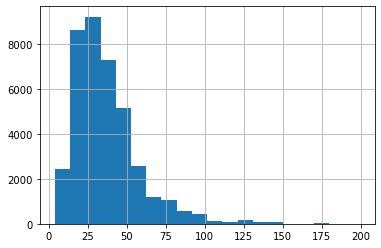

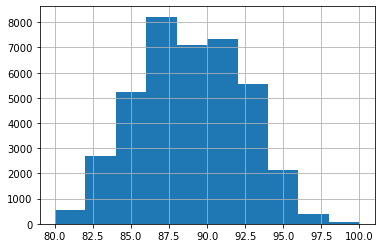

In [12]:
winedata['price'].loc[winedata['price']<200].hist(bins=20)
plt.figure()
winedata['points'].hist()

_<mark><font color = green>然后，处理 points</font><mark>_

In [13]:
bin = [0,75,80,85,90,95,100]
winedata['points'] = pd.cut(winedata['points'],bin)
winedata['points'] = winedata['points'].astype('str')

_<mark><font color = green>再处理 price</font><mark>_

In [14]:
bin = [0,20,30,40,50,60,2100]
winedata['price'] = pd.cut(winedata['price'],bin)
winedata['price'] = winedata['price'].astype('str')

## 三、找出频繁模式

**<font color = blue>使用Aprior算法</font>**

In [17]:
def createC1( dataSet ):
    """
    构建初始候选项集的列表，即所有候选项集只包含一个元素，
    C1是大小为1的所有候选项集的集合
    """
    C1 = []
    for transaction in np.array(dataSet):
        for item in transaction:
            if [item] not in C1:
                C1.append( [item] )
    C1.sort()
    return list(map( frozenset, C1 ))

def scanD( D, Ck, minSupport ):
    """
    计算Ck中的项集在数据集合D(记录或者transactions)中的支持度,
    返回满足最小支持度的项集的集合，和所有项集支持度信息的字典。
    """
    ssCnt = {}
    for tid in D:
        # 对于每一条transaction
        if Ck is not None:
            for can in Ck:
                # 对于每一个候选项集can，检查是否是transaction的一部分
                # 即该候选can是否得到transaction的支持
                if can.issubset( tid ):
                    ssCnt[ can ] = ssCnt.get( can, 0) + 1
    numItems = float( len( D ) )
    retList = []
    supportData = {}
    for key in ssCnt:
        # 每个项集的支持度
        support = ssCnt[ key ] / numItems
        
        # 将满足最小支持度的项集，加入retList
        if support >= minSupport:
            retList.insert( 0, key )
            
            # 汇总支持度数据
            supportData[ key ] = support
    return retList, supportData

In [16]:
# Aprior算法
def aprioriGen( Lk, k ):
    '''
    由初始候选项集的集合Lk生成新的生成候选项集，
    k表示生成的新项集中所含有的元素个数
    '''
    retList = []
    lenLk = len( Lk )
    for i in range( lenLk ):
        for j in range( i + 1, lenLk ):
            L1 = list( Lk[ i ] )[ : k - 2 ];
            L2 = list( Lk[ j ] )[ : k - 2 ];
            L1.sort();L2.sort()    
            if L1==L2:
                retList.append( Lk[ i ] | Lk[ j ] ) 
    return retList

def apriori( dataSet, minSupport = 0.5 ):
    # 构建初始候选项集C1
    C1 = createC1( dataSet )
    
    # 将dataSet集合化，以满足scanD的格式要求
    D =list( map( set, dataSet ))
    
    # 构建初始的频繁项集，即所有项集只有一个元素
    L1, suppData = scanD( D, C1, minSupport )
    L = [ L1 ]
    # 最初的L1中的每个项集含有一个元素，新生成的
    # 项集应该含有2个元素，所以 k=2
    k = 2
    
    while ( len( L[ k - 2 ] ) > 0 ):
        Ck = aprioriGen( L[ k - 2 ], k )
        Lk, supK = scanD( D, Ck, minSupport )
        
        # 将新的项集的支持度数据加入原来的总支持度字典中
        suppData.update( supK )
        
        # 将符合最小支持度要求的项集加入L
        L.append( Lk )
        
        # 新生成的项集中的元素个数应不断增加
        k += 1
    # 返回所有满足条件的频繁项集的列表，和所有候选项集的支持度信息
    return L, suppData

**<font color = blue>然后，输出winedata的频繁项集的列表</font>**

In [47]:
# 支持度大于0.1的频繁项集
myDat = list(map(set,np.array(winedata)))
L, suppData = apriori(myDat, 0.1)
L

[[frozenset({'(80, 85]'}),
  frozenset({'(0, 20]'}),
  frozenset({'(85, 90]'}),
  frozenset({'(30, 40]'}),
  frozenset({'Washington'}),
  frozenset({'Columbia Valley'}),
  frozenset({'Central Coast'}),
  frozenset({'(20, 30]'}),
  frozenset({'Chardonnay'}),
  frozenset({'(40, 50]'}),
  frozenset({'(90, 95]'}),
  frozenset({'Pinot Noir'}),
  frozenset({'Sonoma'}),
  frozenset({'US'}),
  frozenset({'Napa'}),
  frozenset({'California'}),
  frozenset({'Cabernet Sauvignon'}),
  frozenset({'(60, 2100]'})],
 [frozenset({'(80, 85]', 'California'}),
  frozenset({'(80, 85]', 'US'}),
  frozenset({'(85, 90]', 'Central Coast'}),
  frozenset({'(0, 20]', 'California'}),
  frozenset({'(0, 20]', 'US'}),
  frozenset({'(0, 20]', '(85, 90]'}),
  frozenset({'(20, 30]', '(85, 90]'}),
  frozenset({'(30, 40]', 'California'}),
  frozenset({'(30, 40]', 'US'}),
  frozenset({'(85, 90]', 'California'}),
  frozenset({'(85, 90]', 'US'}),
  frozenset({'(30, 40]', '(85, 90]'}),
  frozenset({'Columbia Valley', 'US'}),


## 四、计算支持度和置信度

**<font color = blue>支持度已在‘三’中计算，可调用</font>**

In [28]:
suppData

{frozenset({'(60, 2100]'}): 0.10379450064983053,
 frozenset({'Cabernet Sauvignon'}): 0.12476746260288983,
 frozenset({'California'}): 0.7277337478657526,
 frozenset({'Napa'}): 0.13016997528095614,
 frozenset({'US'}): 1.0,
 frozenset({'Sonoma'}): 0.19841492316709564,
 frozenset({'Pinot Noir'}): 0.19000535154557732,
 frozenset({'(90, 95]'}): 0.271476262072832,
 frozenset({'(40, 50]'}): 0.147549756632094,
 frozenset({'Chardonnay'}): 0.1247419790525216,
 frozenset({'(20, 30]'}): 0.24296016921077446,
 frozenset({'Central Coast'}): 0.2331744858693713,
 frozenset({'Columbia Valley'}): 0.1474223388802528,
 frozenset({'Washington'}): 0.15601029535434877,
 frozenset({'(30, 40]'}): 0.19823653831451798,
 frozenset({'(85, 90]'}): 0.5018730409520654,
 frozenset({'(0, 20]'}): 0.23786345913712698,
 frozenset({'(80, 85]'}): 0.209729619530593,
 frozenset({'Napa', 'US'}): 0.13016997528095614,
 frozenset({'California', 'US'}): 0.7277337478657526,
 frozenset({'Cabernet Sauvignon', 'US'}): 0.124767462602889

**<font color = blue>置信度计算</font>**

In [63]:
confList = []
for itemSet in L:
    for record in itemSet:
        if(len(record)>1): 
            for i in record: 
                tar = suppData[frozenset([i])]
                bset = record - frozenset([i])
                aset = suppData[record]
                ret = suppData.get(bset)
                try:
                    if suppData.get(bset):
                        con = aset/ret
                        print(frozenset([i]),record,con)
                        confList.append([frozenset([i]),record,con])
                except TypeError as e:
                    print(e)

frozenset({'California'}) frozenset({'California', '(80, 85]'}) 0.8234507897934387
frozenset({'(80, 85]'}) frozenset({'California', '(80, 85]'}) 0.2373148439962181
frozenset({'US'}) frozenset({'US', '(80, 85]'}) 1.0
frozenset({'(80, 85]'}) frozenset({'US', '(80, 85]'}) 0.209729619530593
frozenset({'Central Coast'}) frozenset({'Central Coast', '(85, 90]'}) 0.22037168680816493
frozenset({'(85, 90]'}) frozenset({'Central Coast', '(85, 90]'}) 0.4743169398907104
frozenset({'(0, 20]'}) frozenset({'(0, 20]', 'California'}) 0.21521868543614525
frozenset({'California'}) frozenset({'(0, 20]', 'California'}) 0.6584529676451681
frozenset({'US'}) frozenset({'US', '(0, 20]'}) 1.0
frozenset({'(0, 20]'}) frozenset({'US', '(0, 20]'}) 0.23786345913712698
frozenset({'(0, 20]'}) frozenset({'(0, 20]', '(85, 90]'}) 0.25434142378389357
frozenset({'(85, 90]'}) frozenset({'(0, 20]', '(85, 90]'}) 0.5366402399828584
frozenset({'(20, 30]'}) frozenset({'(20, 30]', '(85, 90]'}) 0.28460444805524526
frozenset({'(85, 

## 五、对规则进行评价

**<font color = blue>Lift</font>**

    Lift相关系数
    每个X和评分85-90Y的关系设为
    lift(X->Y) = supp(X U Y)/supp(X) * supp(Y)

In [65]:
def liftCheck(conList,suppData):
    liftList_true=[]
    liftList_no=[]
    liftList_false=[]
    for item in confList:
        score = suppData.get(item[1])/(suppData.get(item[0])*suppData.get(item[1]-item[0]))
        if score>1:
            liftList_true.append(item)
        if score<1:
            liftList_false.append(item)
        if score ==1:
            liftList_no.append(item)
    return liftList_true,liftList_no,liftList_false

In [66]:
yes,no,false = liftCheck(confList,suppData)

In [67]:
"""查看正相关的关联规则"""
yes

[[frozenset({'Washington'}),
  frozenset({'Columbia Valley', 'Washington'}),
  1.0],
 [frozenset({'Columbia Valley'}),
  frozenset({'Columbia Valley', 'Washington'}),
  0.9449526298595231],
 [frozenset({'California'}), frozenset({'California', 'Central Coast'}), 1.0],
 [frozenset({'California'}), frozenset({'California', 'Sonoma'}), 1.0],
 [frozenset({'California'}), frozenset({'California', 'Napa'}), 1.0],
 [frozenset({'California'}),
  frozenset({'(85, 90]', 'California', 'Central Coast'}),
  1.0],
 [frozenset({'Washington'}),
  frozenset({'Columbia Valley', 'US', 'Washington'}),
  1.0],
 [frozenset({'Columbia Valley'}),
  frozenset({'Columbia Valley', 'US', 'Washington'}),
  0.9449526298595231],
 [frozenset({'California'}),
  frozenset({'California', 'Central Coast', 'US'}),
  1.0],
 [frozenset({'California'}), frozenset({'California', 'Sonoma', 'US'}), 1.0],
 [frozenset({'California'}), frozenset({'California', 'Napa', 'US'}), 1.0],
 [frozenset({'California'}),
  frozenset({'(85, 9

**<font color = blue>全自信度</font>**

    全自信度检验
    全自信度all_confidence的定义如下：
    all_confidence(A,B)=P(A交B)/max{P(A),P(B)}
     =min{P(B|A),P(A|B)}
     =min{confidence(A—>B),confidence(B—>A)}

In [76]:
def all_confidence(conList,suppData):
    result = []
    for item in confList:
        score = suppData.get(item[1])/max(suppData.get(item[0]),suppData.get(item[1]-item[0]))
        result.append(['全自信度为:{0}'.format(score),item])
    return result

In [80]:
conf = all_confidence(confList,suppData)
conf

[['全自信度为:0.209729619530593',
  [frozenset({'US'}), frozenset({'(80, 85]', 'US'}), 1.0]],
 ['全自信度为:0.23786345913712698',
  [frozenset({'US'}), frozenset({'(0, 20]', 'US'}), 1.0]],
 ['全自信度为:0.19823653831451798',
  [frozenset({'US'}), frozenset({'(30, 40]', 'US'}), 1.0]],
 ['全自信度为:0.5018730409520654',
  [frozenset({'US'}), frozenset({'(85, 90]', 'US'}), 1.0]],
 ['全自信度为:0.1474223388802528',
  [frozenset({'US'}), frozenset({'Columbia Valley', 'US'}), 1.0]],
 ['全自信度为:0.15601029535434877',
  [frozenset({'US'}), frozenset({'US', 'Washington'}), 1.0]],
 ['全自信度为:0.9449526298595231',
  [frozenset({'Washington'}),
   frozenset({'Columbia Valley', 'Washington'}),
   1.0]],
 ['全自信度为:0.9449526298595231',
  [frozenset({'Columbia Valley'}),
   frozenset({'Columbia Valley', 'Washington'}),
   0.9449526298595231]],
 ['全自信度为:0.3204118079630213',
  [frozenset({'California'}),
   frozenset({'California', 'Central Coast'}),
   1.0]],
 ['全自信度为:0.2331744858693713',
  [frozenset({'US'}), frozenset({'Central Coa

## 六、可视化

**<font color = blue>支持度与置信度可视化</font>**

In [98]:
item = conf[0]
support = item[1][2]
confidence = item[0].split(':')[1]

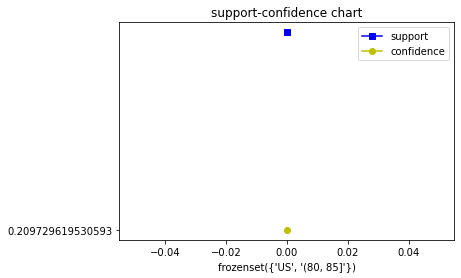

In [108]:

k1 = support 
k2 = confidence  
plt.plot( k1, 's-', color = 'b', label="support")  
plt.plot( k2, 'o-', color = 'y', label="confidence")  
plt.xlabel(item[1][1]) 
plt.legend(loc="best") 
plt.title("support-confidence chart")
plt.show()

# 七、实验分析

    本实验通过Apriori算法按照support，confidence，LIFT等指标计算出了频繁项集和他们之间的关系，挖掘出了关于葡萄酒产地与评分、与价格之间的关系